In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for dealing with null values
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Data Pre-processing Libraries
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split

# Modelling Libraries
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Evaluation & CV Libraries
from sklearn.metrics import precision_score,accuracy_score
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV,StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix
import warnings
import optuna
from optuna.samplers import TPESampler

In [2]:
# File and Data Field Descriptions
# train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
    # PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
    # HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
    # CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
    # Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
    # Destination - The planet the passenger will be debarking to.
    # Age - The age of the passenger.
    # VIP - Whether the passenger has paid for special VIP service during the voyage.
    # RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
    # Name - The first and last names of the passenger.
    # Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.
# test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.
# sample_submission.csv - A submission file in the correct format.
    # PassengerId - Id for each passenger in the test set.
    # Transported - The target. For each passenger, predict either True or False.

In [3]:
ss=pd.read_csv('sample_submission.csv')
print("Number of nunique Id's: {:.1f}".format(ss['PassengerId'].nunique()))
print("Number of Transported: ", ss['Transported'].value_counts(normalize=True))

Number of nunique Id's: 4277.0
Number of Transported:  False    1.0
Name: Transported, dtype: float64


In [4]:
test=pd.read_csv('test.csv')
train=pd.read_csv('train.csv')

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [7]:
# merge test.csv and sample_submission.csv  on PassengerId
df1 = pd.merge(test, ss, how='inner', on='PassengerId')
df1['train_test'] = 'test'

In [8]:
# concatenate new df1 and train.csv
train['train_test'] = 'train'
df = pd.concat([train,df1]).reset_index(drop=True)
df.sample(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,train_test
2997,3240_01,Earth,False,E/216/S,TRAPPIST-1e,17.0,False,0.0,382.0,402.0,0.0,7.0,Sonnie Vinozarks,False,train
4124,4401_01,Earth,NaN,G/716/S,55 Cancri e,16.0,False,0.0,0.0,0.0,0.0,0.0,Tonyan Loverthyo,True,train
147,0167_02,Mars,False,F/35/S,TRAPPIST-1e,27.0,False,1365.0,0.0,48.0,22.0,137.0,Rios Floaf,False,train
8664,9246_01,Earth,NaN,G/1490/S,TRAPPIST-1e,32.0,False,0.0,0.0,0.0,0.0,0.0,NaN,True,train
1933,2067_02,Europa,False,C/70/P,TRAPPIST-1e,27.0,True,0.0,0.0,72.0,668.0,2713.0,Asellan Sprender,False,train


In [9]:
# checking null values in df
df.isnull().sum()

PassengerId       0
HomePlanet      288
CryoSleep       310
Cabin           299
Destination     274
Age             270
VIP             296
RoomService     263
FoodCourt       289
ShoppingMall    306
Spa             284
VRDeck          268
Name            294
Transported       0
train_test        0
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   12970 non-null  bool   
 14  train_test    12970 non-null  object 
dtypes: bool(1), float64(6), object(8)
memory usage: 1.4+ MB


In [11]:
df.drop('Name', axis=1, inplace=True)

## Dealing with missing values

In [12]:
# when people are in Cryosleep don't pay for luxury amenities
df[df['CryoSleep']==True].describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,4467.000000,4488.0,4472.0,4450.0,4474.0,4490.0
mean,27.510857,0.0,0.0,0.0,0.0,0.0
std,14.887864,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0
25%,18.000000,0.0,0.0,0.0,0.0,0.0
50%,26.000000,0.0,0.0,0.0,0.0,0.0
75%,37.000000,0.0,0.0,0.0,0.0,0.0
max,78.000000,0.0,0.0,0.0,0.0,0.0


In [13]:
df[df['CryoSleep']==False].describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,7926.000000,7912.000000,7902.000000,7914.000000,7909.000000,7910.000000
mean,29.484229,349.153185,709.269046,274.165782,482.310532,481.595196
std,14.030870,781.652731,1945.240029,723.914453,1375.663790,1453.900973
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,3.000000,6.000000,2.000000,8.000000,3.000000
75%,38.000000,399.000000,539.750000,250.500000,364.000000,342.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [14]:
df[df['CryoSleep']==True].isnull().sum()

PassengerId       0
HomePlanet      103
CryoSleep         0
Cabin           119
Destination      80
Age             114
VIP             104
RoomService      93
FoodCourt       109
ShoppingMall    131
Spa             107
VRDeck           91
Transported       0
train_test        0
dtype: int64

In [15]:
# changing if cryoleep is true, all the luxury amenities to 0
df["RoomService"] = np.where(((df["CryoSleep"] == True) & (df["RoomService"].isnull())), 0, df["RoomService"])
df["FoodCourt"] = np.where(((df["CryoSleep"] == True) & (df["FoodCourt"].isnull())), 0, df["FoodCourt"])
df["ShoppingMall"] = np.where(((df["CryoSleep"] == True) & (df["ShoppingMall"].isnull())), 0, df["ShoppingMall"])
df["Spa"] = np.where(((df["CryoSleep"] == True) & (df["Spa"].isnull())), 0, df["Spa"])
df["VRDeck"] = np.where(((df["CryoSleep"] == True) & (df["VRDeck"].isnull())), 0, df["VRDeck"])
df[df['CryoSleep']==True].isnull().sum()

PassengerId       0
HomePlanet      103
CryoSleep         0
Cabin           119
Destination      80
Age             114
VIP             104
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
train_test        0
dtype: int64

In [16]:
# split Cabin column to 3 new columns deck/num/side, where side can be either P for Port or S for Starboard.
df[['Cabin_deck', 'Cabin_no', 'Cabin_side']] = df['Cabin'].str.split('/', expand=True)
df[['Passenger_no', 'Passenger_group']] = df['PassengerId'].str.split('_', expand=True)

In [17]:
df_pivot = pd.pivot_table(df, index='Cabin_deck', columns='HomePlanet', values='Cabin' , aggfunc='count')
df_pivot

HomePlanet,Earth,Europa,Mars
Cabin_deck,,,
A,NaN,346.0,NaN
B,NaN,1124.0,NaN
C,NaN,1081.0,NaN
D,NaN,296.0,406.0
E,583.0,197.0,508.0
F,2426.0,NaN,1713.0
G,3700.0,NaN,NaN
T,NaN,10.0,NaN


In [18]:
# fill Nan's on HomePlanet, according to Cabin_deck
df["HomePlanet"] = np.where(((df["Cabin_deck"] == 'G') & (df["HomePlanet"].isnull())), 'Earth', df["HomePlanet"])
df["HomePlanet"] = np.where(((df["Cabin_deck"] == 'A') & (df["HomePlanet"].isnull())), 'Europa', df["HomePlanet"])
df["HomePlanet"] = np.where(((df["Cabin_deck"] == 'B') & (df["HomePlanet"].isnull())), 'Europa', df["HomePlanet"])
df["HomePlanet"] = np.where(((df["Cabin_deck"] == 'C') & (df["HomePlanet"].isnull())), 'Europa', df["HomePlanet"])
df["HomePlanet"] = np.where(((df["Cabin_deck"] == 'T') & (df["HomePlanet"].isnull())), 'Europa', df["HomePlanet"])

In [19]:
# drop columns that are not helpful
df.drop(['PassengerId', 'Cabin', 'Cabin_no', 'Passenger_no'], axis=1, inplace=True)

In [20]:
# for the rest missing values I'll use Iterative Imputer
# Transform categorical data with 3 values to digits
df['HomePlanet'] = df['HomePlanet'].replace({'Mars': 1, 'Europa':2, 'Earth':3})
df['Destination'] = df['Destination'].replace({'55 Cancri e': 1, 'TRAPPIST-1e':2, 'PSO J318.5-22':3})
df['Cabin_deck'] = df['Cabin_deck'].replace({'A': 1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7, 'T':8})
df['Cabin_side'] = df['Cabin_side'].replace({'P': 1, 'S':2})
df['train_test'] = df['train_test'].replace({'test': 0, 'train':1})
df

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,train_test,Cabin_deck,Cabin_side,Passenger_group
0,2.0,False,2.0,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1,2.0,1.0,01
1,3.0,False,2.0,24.0,False,109.0,9.0,25.0,549.0,44.0,True,1,6.0,2.0,01
2,2.0,False,2.0,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,1,1.0,2.0,01
3,2.0,False,2.0,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,1,1.0,2.0,02
4,3.0,False,2.0,16.0,False,303.0,70.0,151.0,565.0,2.0,True,1,6.0,2.0,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,3.0,True,2.0,34.0,False,0.0,0.0,0.0,0.0,0.0,False,0,7.0,2.0,02
12966,3.0,False,2.0,42.0,False,0.0,847.0,17.0,10.0,144.0,False,0,NaN,NaN,01
12967,1.0,True,1.0,NaN,False,0.0,0.0,0.0,0.0,0.0,False,0,4.0,1.0,01
12968,2.0,False,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,False,0,4.0,1.0,01


In [21]:
imputer = IterativeImputer(random_state=42)
imputed = imputer.fit_transform(df)
df_imputed = pd.DataFrame(imputed, columns=df.columns)

In [22]:
df_imputed.isnull().sum()

HomePlanet         0
CryoSleep          0
Destination        0
Age                0
VIP                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Transported        0
train_test         0
Cabin_deck         0
Cabin_side         0
Passenger_group    0
dtype: int64

In [23]:
df_imputed.describe()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,train_test,Cabin_deck,Cabin_side,Passenger_group
count,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000
mean,2.332894,0.361952,1.885388,28.774702,0.021575,222.744848,450.918207,174.273597,307.590424,306.211332,0.337548,0.670239,5.321051,1.503609,1.511488
std,0.796236,0.476448,0.531609,14.252748,0.143623,641.866031,1569.273236,584.038178,1118.847209,1168.915878,0.472892,0.470144,1.747056,0.494252,1.042500
min,1.000000,-1.378754,1.000000,0.000000,-0.028112,-397.336428,-529.228284,-160.439060,-212.099871,-249.506906,0.000000,0.000000,0.968212,1.000000,1.000000
25%,2.000000,0.000000,2.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,1.000000
50%,3.000000,0.000000,2.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,1.526583,1.000000
75%,3.000000,1.000000,2.000000,37.000000,0.000000,61.000000,90.000000,35.000000,68.000000,52.000000,1.000000,1.000000,7.000000,2.000000,2.000000
max,3.000000,1.000000,3.000000,79.000000,1.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1.000000,1.000000,8.000000,2.000000,8.000000


In [24]:
# changing digits again to categories
df_imputed["HomePlanet"] = pd.cut( x=df_imputed["HomePlanet"], bins=[-2, 1.5, 2.5, np.inf],
                                  labels=['Mars', 'Europa', 'Earth'])
df_imputed["Destination"] = pd.cut( x=df_imputed["Destination"], bins=[-2, 1.5, 2.5, np.inf],
                                  labels=['55 Cancri e', 'TRAPPIST-1e', 'PSO J318.5-22'])
df_imputed["CryoSleep"] = pd.cut( x=df_imputed["CryoSleep"], bins=[-2, 0.5, np.inf],
                                  labels=['False', 'True'])
df_imputed["VIP"] = pd.cut( x=df_imputed["VIP"], bins=[-1, 0.5, np.inf],
                                  labels=['False', 'True'])
df_imputed["Cabin_side"] = pd.cut( x=df_imputed["Cabin_side"], bins=[0, 1.5, np.inf],
                                  labels=['Port', 'Starboard'])
df_imputed["Cabin_deck"] = pd.cut( x=df_imputed["Cabin_deck"], bins=[0, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5],
                                  labels=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'])
round(df_imputed,0)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,train_test,Cabin_deck,Cabin_side,Passenger_group
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0.0,1.0,B,Port,1.0
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,1.0,1.0,F,Starboard,1.0
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,0.0,1.0,A,Starboard,1.0
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,0.0,1.0,A,Starboard,2.0
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,1.0,1.0,F,Starboard,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,Earth,True,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,G,Starboard,2.0
12966,Earth,False,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,0.0,0.0,F,Starboard,1.0
12967,Mars,True,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,D,Port,1.0
12968,Europa,False,TRAPPIST-1e,33.0,False,0.0,2680.0,0.0,0.0,523.0,0.0,0.0,D,Port,1.0


In [25]:
# create again train set
train = df_imputed[df_imputed['train_test'] == 1]
train.drop(['train_test'], axis=1, inplace=True)
train.shape

C:\Users\HP\AppData\Local\Temp\ipykernel_19416\860867335.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(['train_test'], axis=1, inplace=True)


(8693, 14)

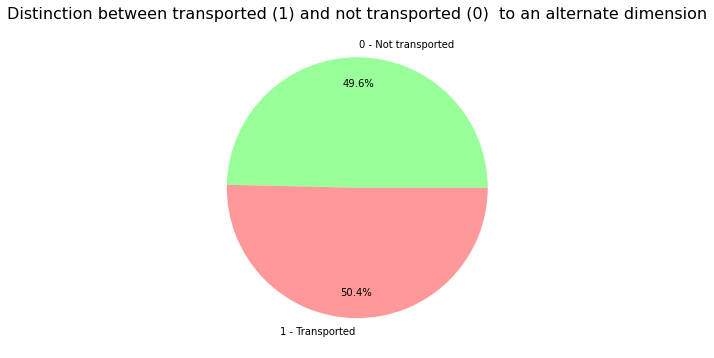

In [26]:
# create pie chart
clas = dict(train.groupby('Transported')['Transported'].count())
labels = ['0 - Not transported', '1 - Transported']
colors = ['#99ff99', '#ff9999']
values = clas.values()
plt.figure(figsize=(6,6))
plt.pie(data=df, x=values, labels=labels, autopct = '%1.1f%%', pctdistance=0.8, colors=colors)
plt.title('Distinction between transported (1) and not transported (0)  to an alternate dimension', fontsize=16)
plt.show()

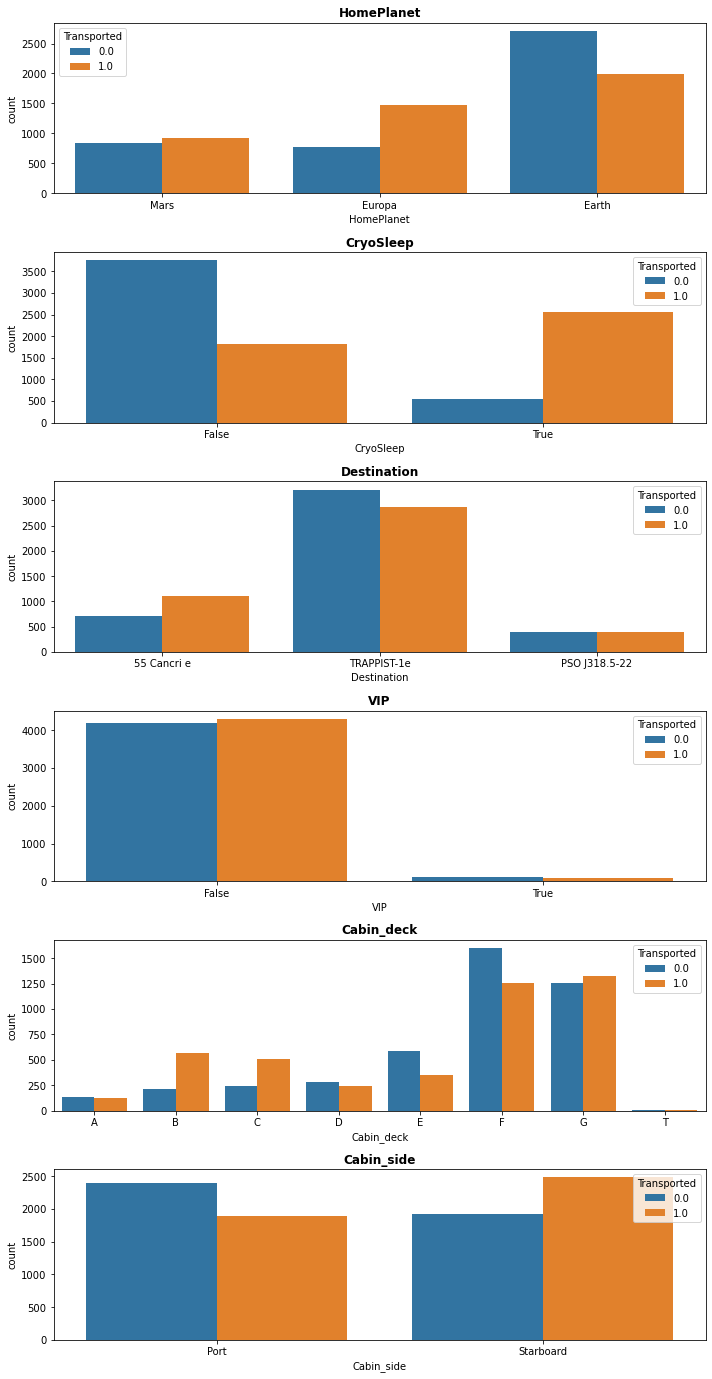

In [27]:
fig=plt.figure(figsize=(10, 22))
for i, var_name in enumerate(['HomePlanet','CryoSleep','Destination','VIP', 'Cabin_deck', 'Cabin_side']):
    ax=fig.add_subplot(7, 1, i+1)
    sns.countplot(data=train, x=var_name, axes=ax, hue='Transported')
    ax.set_title(var_name, fontsize=12, fontweight='bold')
fig.tight_layout()  # Improves appearance a bit
plt.show()

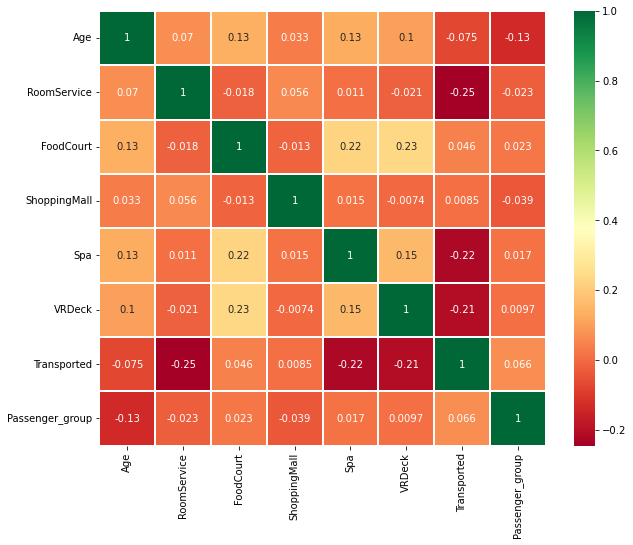

In [28]:
corr=train.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='RdYlGn', linewidths=0.05)
plt.show()

In [29]:
# create again test set
test = df_imputed[df_imputed['train_test'] == 0]
test.drop(['train_test'], axis=1, inplace=True)

C:\Users\HP\AppData\Local\Temp\ipykernel_19416\3971200288.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(['train_test'], axis=1, inplace=True)


## One Hot Encoding

In [30]:
train_ohe = pd.get_dummies(data=train, columns=['HomePlanet', 'CryoSleep', 'Destination', 
                                                'VIP', 'Cabin_deck', 'Cabin_side'])
test_ohe = pd.get_dummies(data=test, columns=['HomePlanet', 'CryoSleep', 'Destination', 
                                                'VIP', 'Cabin_deck', 'Cabin_side'])

## Standardizing The Data

In [31]:
X_train = train_ohe.drop('Transported',axis=1)
y_train = train_ohe['Transported']
X_test = test_ohe.drop('Transported',axis=1)
y_test = test_ohe['Transported']

In [32]:
# I'll be working on train set
X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size=0.2,random_state=42)

print("X_train1 : " + str(X_train1.shape))
print("X_validation : " + str(X_val.shape))
print("y_train1 : " + str(y_train1.shape))
print("y_validation : " + str(y_val.shape))

X_train1 : (6954, 27)
X_validation : (1739, 27)
y_train1 : (6954,)
y_validation : (1739,)


In [33]:
scaler = StandardScaler()
scaler.fit(X_train1)
X_train1 = scaler.transform(X_train1)
X_val = scaler.transform(X_val)

## Modelling

In [41]:
warnings.filterwarnings('ignore')

In [42]:
models =[("CAT", CatBoostClassifier(random_state=42)), ("LGBM", LGBMClassifier(random_state=42)),
         ("XGB", XGBClassifier(random_state=42))]

results = []
names = []
finalResults = []

for name,model in models:
    model.fit(X_train1, y_train1)
    model_results = model.predict(X_val)
    score = accuracy_score(y_val, model_results)
    results.append(score)
    names.append(name)
    finalResults.append((name,score))
    
finalResults.sort(key=lambda k:k[1],reverse=True)

Learning rate set to 0.023581
0:	learn: 0.6811042	total: 163ms	remaining: 2m 42s
1:	learn: 0.6702574	total: 170ms	remaining: 1m 24s
2:	learn: 0.6591506	total: 176ms	remaining: 58.5s
3:	learn: 0.6478356	total: 182ms	remaining: 45.4s
4:	learn: 0.6367163	total: 187ms	remaining: 37.3s
5:	learn: 0.6265699	total: 193ms	remaining: 32.1s
6:	learn: 0.6185461	total: 198ms	remaining: 28.1s
7:	learn: 0.6106372	total: 203ms	remaining: 25.2s
8:	learn: 0.6019045	total: 208ms	remaining: 22.9s
9:	learn: 0.5935472	total: 211ms	remaining: 20.9s
10:	learn: 0.5874060	total: 214ms	remaining: 19.3s
11:	learn: 0.5795503	total: 218ms	remaining: 18s
12:	learn: 0.5724378	total: 223ms	remaining: 16.9s
13:	learn: 0.5672978	total: 228ms	remaining: 16.1s
14:	learn: 0.5620044	total: 231ms	remaining: 15.2s
15:	learn: 0.5565259	total: 236ms	remaining: 14.5s
16:	learn: 0.5506884	total: 242ms	remaining: 14s
17:	learn: 0.5456969	total: 247ms	remaining: 13.5s
18:	learn: 0.5403164	total: 252ms	remaining: 13s
19:	learn: 0.53

204:	learn: 0.3825348	total: 880ms	remaining: 3.41s
205:	learn: 0.3823620	total: 884ms	remaining: 3.41s
206:	learn: 0.3822543	total: 889ms	remaining: 3.4s
207:	learn: 0.3821423	total: 892ms	remaining: 3.4s
208:	learn: 0.3820256	total: 895ms	remaining: 3.39s
209:	learn: 0.3818116	total: 898ms	remaining: 3.38s
210:	learn: 0.3816735	total: 901ms	remaining: 3.37s
211:	learn: 0.3815778	total: 904ms	remaining: 3.36s
212:	learn: 0.3812435	total: 907ms	remaining: 3.35s
213:	learn: 0.3811103	total: 910ms	remaining: 3.34s
214:	learn: 0.3810102	total: 914ms	remaining: 3.34s
215:	learn: 0.3808930	total: 917ms	remaining: 3.33s
216:	learn: 0.3806966	total: 920ms	remaining: 3.32s
217:	learn: 0.3805795	total: 923ms	remaining: 3.31s
218:	learn: 0.3804586	total: 926ms	remaining: 3.3s
219:	learn: 0.3803031	total: 930ms	remaining: 3.3s
220:	learn: 0.3800798	total: 933ms	remaining: 3.29s
221:	learn: 0.3799676	total: 936ms	remaining: 3.28s
222:	learn: 0.3798436	total: 940ms	remaining: 3.27s
223:	learn: 0.37

393:	learn: 0.3578201	total: 1.59s	remaining: 2.45s
394:	learn: 0.3577527	total: 1.6s	remaining: 2.45s
395:	learn: 0.3576513	total: 1.6s	remaining: 2.44s
396:	learn: 0.3575847	total: 1.6s	remaining: 2.44s
397:	learn: 0.3575338	total: 1.61s	remaining: 2.43s
398:	learn: 0.3574123	total: 1.61s	remaining: 2.43s
399:	learn: 0.3572631	total: 1.62s	remaining: 2.42s
400:	learn: 0.3572055	total: 1.62s	remaining: 2.42s
401:	learn: 0.3571468	total: 1.62s	remaining: 2.42s
402:	learn: 0.3569911	total: 1.63s	remaining: 2.41s
403:	learn: 0.3567961	total: 1.63s	remaining: 2.41s
404:	learn: 0.3566866	total: 1.64s	remaining: 2.4s
405:	learn: 0.3566387	total: 1.64s	remaining: 2.4s
406:	learn: 0.3565963	total: 1.64s	remaining: 2.39s
407:	learn: 0.3565249	total: 1.64s	remaining: 2.39s
408:	learn: 0.3564544	total: 1.65s	remaining: 2.38s
409:	learn: 0.3563466	total: 1.65s	remaining: 2.38s
410:	learn: 0.3562681	total: 1.65s	remaining: 2.37s
411:	learn: 0.3561691	total: 1.66s	remaining: 2.36s
412:	learn: 0.356

553:	learn: 0.3420964	total: 2.13s	remaining: 1.71s
554:	learn: 0.3420161	total: 2.13s	remaining: 1.71s
555:	learn: 0.3418545	total: 2.14s	remaining: 1.71s
556:	learn: 0.3417383	total: 2.14s	remaining: 1.7s
557:	learn: 0.3416555	total: 2.14s	remaining: 1.7s
558:	learn: 0.3415240	total: 2.15s	remaining: 1.69s
559:	learn: 0.3414377	total: 2.15s	remaining: 1.69s
560:	learn: 0.3413537	total: 2.15s	remaining: 1.69s
561:	learn: 0.3412806	total: 2.16s	remaining: 1.68s
562:	learn: 0.3412330	total: 2.16s	remaining: 1.68s
563:	learn: 0.3411118	total: 2.16s	remaining: 1.67s
564:	learn: 0.3409137	total: 2.17s	remaining: 1.67s
565:	learn: 0.3408837	total: 2.17s	remaining: 1.66s
566:	learn: 0.3408199	total: 2.17s	remaining: 1.66s
567:	learn: 0.3407082	total: 2.18s	remaining: 1.66s
568:	learn: 0.3406308	total: 2.18s	remaining: 1.65s
569:	learn: 0.3405412	total: 2.18s	remaining: 1.65s
570:	learn: 0.3405143	total: 2.19s	remaining: 1.64s
571:	learn: 0.3404327	total: 2.19s	remaining: 1.64s
572:	learn: 0.

762:	learn: 0.3236745	total: 2.84s	remaining: 883ms
763:	learn: 0.3236025	total: 2.85s	remaining: 879ms
764:	learn: 0.3235567	total: 2.85s	remaining: 876ms
765:	learn: 0.3234089	total: 2.85s	remaining: 872ms
766:	learn: 0.3232506	total: 2.86s	remaining: 868ms
767:	learn: 0.3231975	total: 2.86s	remaining: 864ms
768:	learn: 0.3231919	total: 2.86s	remaining: 860ms
769:	learn: 0.3231334	total: 2.87s	remaining: 856ms
770:	learn: 0.3230638	total: 2.87s	remaining: 852ms
771:	learn: 0.3229381	total: 2.87s	remaining: 848ms
772:	learn: 0.3228080	total: 2.88s	remaining: 845ms
773:	learn: 0.3226847	total: 2.88s	remaining: 841ms
774:	learn: 0.3225263	total: 2.88s	remaining: 837ms
775:	learn: 0.3223199	total: 2.88s	remaining: 833ms
776:	learn: 0.3222725	total: 2.89s	remaining: 829ms
777:	learn: 0.3221849	total: 2.89s	remaining: 825ms
778:	learn: 0.3221719	total: 2.9s	remaining: 821ms
779:	learn: 0.3221022	total: 2.9s	remaining: 818ms
780:	learn: 0.3220205	total: 2.9s	remaining: 814ms
781:	learn: 0.3

939:	learn: 0.3087349	total: 3.56s	remaining: 227ms
940:	learn: 0.3086672	total: 3.56s	remaining: 224ms
941:	learn: 0.3086446	total: 3.57s	remaining: 220ms
942:	learn: 0.3085428	total: 3.57s	remaining: 216ms
943:	learn: 0.3084953	total: 3.58s	remaining: 212ms
944:	learn: 0.3084785	total: 3.58s	remaining: 208ms
945:	learn: 0.3084029	total: 3.58s	remaining: 205ms
946:	learn: 0.3083053	total: 3.59s	remaining: 201ms
947:	learn: 0.3082323	total: 3.59s	remaining: 197ms
948:	learn: 0.3082156	total: 3.59s	remaining: 193ms
949:	learn: 0.3080849	total: 3.6s	remaining: 189ms
950:	learn: 0.3079934	total: 3.6s	remaining: 186ms
951:	learn: 0.3079562	total: 3.61s	remaining: 182ms
952:	learn: 0.3078289	total: 3.61s	remaining: 178ms
953:	learn: 0.3077342	total: 3.61s	remaining: 174ms
954:	learn: 0.3076213	total: 3.62s	remaining: 170ms
955:	learn: 0.3075590	total: 3.62s	remaining: 167ms
956:	learn: 0.3074554	total: 3.62s	remaining: 163ms
957:	learn: 0.3073703	total: 3.63s	remaining: 159ms
958:	learn: 0.

In [43]:
finalResults  # Accuracy score

[('LGBM', 0.8108108108108109),
 ('XGB', 0.8096607245543416),
 ('CAT', 0.8067855089131685)]

## Hyperparameters tuning

### XGB hyperparameters tunig using optuna

In [137]:
def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'random_state':42,
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }

    # Fit the model
    optuna_model = XGBClassifier(**params)
    optuna_model.fit(X_train1, y_train1)

    # Make predictions
    y_pred = optuna_model.predict(X_val)

    # Evaluate predictions
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy

In [138]:
study = optuna.create_study(direction='maximize')

[I 2023-03-22 13:58:47,173] A new study created in memory with name: no-name-9d61933a-e94b-4176-a57d-d8d3f64ae036


In [139]:
study.optimize(objective, n_trials=200)

[I 2023-03-22 13:58:56,698] Trial 0 finished with value: 0.7487061529614721 and parameters: {'max_depth': 7, 'learning_rate': 0.17131374786440992, 'n_estimators': 82, 'min_child_weight': 3, 'gamma': 0.10242941309693449, 'subsample': 0.6111639084904743, 'colsample_bytree': 0.012396803766968808, 'reg_alpha': 0.16983593778343437, 'reg_lambda': 4.8493987568449415e-06}. Best is trial 0 with value: 0.7487061529614721.
[I 2023-03-22 13:58:57,141] Trial 1 finished with value: 0.777458309373203 and parameters: {'max_depth': 5, 'learning_rate': 0.055632624752663014, 'n_estimators': 414, 'min_child_weight': 3, 'gamma': 0.0006156676171102739, 'subsample': 0.28745871334142714, 'colsample_bytree': 0.048070338661826216, 'reg_alpha': 0.0003563700488015453, 'reg_lambda': 0.0022276386407746995}. Best is trial 1 with value: 0.777458309373203.
[I 2023-03-22 13:58:57,204] Trial 2 finished with value: 0.7429557216791259 and parameters: {'max_depth': 4, 'learning_rate': 0.013028475111121382, 'n_estimators': 

[I 2023-03-22 13:59:04,817] Trial 19 finished with value: 0.7153536515238643 and parameters: {'max_depth': 6, 'learning_rate': 0.018285334788956355, 'n_estimators': 184, 'min_child_weight': 10, 'gamma': 9.391120467877242e-08, 'subsample': 0.012644806818375659, 'colsample_bytree': 0.4162357869616946, 'reg_alpha': 1.0029266117683275e-06, 'reg_lambda': 0.0003216867924819419}. Best is trial 16 with value: 0.8021851638872916.
[I 2023-03-22 13:59:05,218] Trial 20 finished with value: 0.7998849913743531 and parameters: {'max_depth': 3, 'learning_rate': 0.03658347415083315, 'n_estimators': 292, 'min_child_weight': 4, 'gamma': 2.7279144647376284e-07, 'subsample': 0.18006232186096488, 'colsample_bytree': 0.22332721860929766, 'reg_alpha': 1.6440785291680786e-07, 'reg_lambda': 4.176573947597058e-05}. Best is trial 16 with value: 0.8021851638872916.
[I 2023-03-22 13:59:05,582] Trial 21 finished with value: 0.7998849913743531 and parameters: {'max_depth': 3, 'learning_rate': 0.03792838416380934, 'n_

[I 2023-03-22 13:59:26,492] Trial 38 finished with value: 0.8079355951696378 and parameters: {'max_depth': 4, 'learning_rate': 0.05080573135776533, 'n_estimators': 394, 'min_child_weight': 9, 'gamma': 3.0057412006849474e-08, 'subsample': 0.7642729150837247, 'colsample_bytree': 0.5044789148410562, 'reg_alpha': 0.00011904646001982448, 'reg_lambda': 4.602717419372922e-07}. Best is trial 38 with value: 0.8079355951696378.
[I 2023-03-22 13:59:27,644] Trial 39 finished with value: 0.7987349051178838 and parameters: {'max_depth': 3, 'learning_rate': 0.053251946774426226, 'n_estimators': 344, 'min_child_weight': 7, 'gamma': 1.7165978060912577e-06, 'subsample': 0.3944558890494456, 'colsample_bytree': 0.5578142023350722, 'reg_alpha': 0.9016900538635348, 'reg_lambda': 6.502657473681799e-08}. Best is trial 38 with value: 0.8079355951696378.
[I 2023-03-22 13:59:29,227] Trial 40 finished with value: 0.7935595169637722 and parameters: {'max_depth': 4, 'learning_rate': 0.10987129983438167, 'n_estimato

[I 2023-03-22 13:59:53,989] Trial 57 finished with value: 0.7998849913743531 and parameters: {'max_depth': 5, 'learning_rate': 0.126227265355681, 'n_estimators': 452, 'min_child_weight': 8, 'gamma': 2.317122090657098e-08, 'subsample': 0.2705392654251435, 'colsample_bytree': 0.33258538004232874, 'reg_alpha': 9.182801183359007e-05, 'reg_lambda': 7.62163966264149e-08}. Best is trial 38 with value: 0.8079355951696378.
[I 2023-03-22 13:59:55,230] Trial 58 finished with value: 0.7941345600920069 and parameters: {'max_depth': 2, 'learning_rate': 0.032640047900922536, 'n_estimators': 478, 'min_child_weight': 6, 'gamma': 3.29461289312764e-07, 'subsample': 0.820159348138308, 'colsample_bytree': 0.6359890234235052, 'reg_alpha': 4.171758326200023e-06, 'reg_lambda': 1.0443861275673415e-08}. Best is trial 38 with value: 0.8079355951696378.
[I 2023-03-22 13:59:56,469] Trial 59 finished with value: 0.8010350776308223 and parameters: {'max_depth': 3, 'learning_rate': 0.04027904766219633, 'n_estimators'

[I 2023-03-22 14:00:21,396] Trial 76 finished with value: 0.8021851638872916 and parameters: {'max_depth': 5, 'learning_rate': 0.08054635210537688, 'n_estimators': 437, 'min_child_weight': 8, 'gamma': 2.255868493186445e-07, 'subsample': 0.5229065184906186, 'colsample_bytree': 0.4013529748288813, 'reg_alpha': 1.91531076294066e-05, 'reg_lambda': 2.313046822577722e-07}. Best is trial 38 with value: 0.8079355951696378.
[I 2023-03-22 14:00:22,511] Trial 77 finished with value: 0.7981598619896493 and parameters: {'max_depth': 4, 'learning_rate': 0.05557298684024998, 'n_estimators': 359, 'min_child_weight': 9, 'gamma': 1.0674879701496948e-08, 'subsample': 0.85480597693208, 'colsample_bytree': 0.49713095851494576, 'reg_alpha': 4.4085155732399106e-05, 'reg_lambda': 1.1022431781362981e-06}. Best is trial 38 with value: 0.8079355951696378.
[I 2023-03-22 14:00:24,778] Trial 78 finished with value: 0.8027602070155262 and parameters: {'max_depth': 6, 'learning_rate': 0.045450395006862716, 'n_estimat

[I 2023-03-22 14:00:53,114] Trial 95 finished with value: 0.7952846463484762 and parameters: {'max_depth': 8, 'learning_rate': 0.05509236346630598, 'n_estimators': 454, 'min_child_weight': 10, 'gamma': 5.177470247568625e-07, 'subsample': 0.5528069216124928, 'colsample_bytree': 0.7293453750249574, 'reg_alpha': 1.4758541526829933e-05, 'reg_lambda': 1.5145462869753314e-07}. Best is trial 38 with value: 0.8079355951696378.
[I 2023-03-22 14:00:54,492] Trial 96 finished with value: 0.8016101207590569 and parameters: {'max_depth': 3, 'learning_rate': 0.09714264449327882, 'n_estimators': 483, 'min_child_weight': 9, 'gamma': 2.3818407741671935e-07, 'subsample': 0.6517122804680927, 'colsample_bytree': 0.5861212879786895, 'reg_alpha': 2.3361974175521984e-05, 'reg_lambda': 6.09295352299495e-07}. Best is trial 38 with value: 0.8079355951696378.
[I 2023-03-22 14:00:56,276] Trial 97 finished with value: 0.8033352501437608 and parameters: {'max_depth': 5, 'learning_rate': 0.06864196205027788, 'n_estim

[I 2023-03-22 14:01:23,251] Trial 114 finished with value: 0.8004600345025877 and parameters: {'max_depth': 5, 'learning_rate': 0.07717146877272979, 'n_estimators': 432, 'min_child_weight': 10, 'gamma': 1.4966313726256198e-07, 'subsample': 0.5213107046081578, 'colsample_bytree': 0.5355058256707649, 'reg_alpha': 0.00027876425333320026, 'reg_lambda': 9.392405577526099e-08}. Best is trial 107 with value: 0.8085106382978723.
[I 2023-03-22 14:01:25,192] Trial 115 finished with value: 0.8021851638872916 and parameters: {'max_depth': 5, 'learning_rate': 0.04409759554255451, 'n_estimators': 490, 'min_child_weight': 9, 'gamma': 1.382966076129909e-08, 'subsample': 0.5765344775105025, 'colsample_bytree': 0.48676081949300903, 'reg_alpha': 5.777913167300397e-05, 'reg_lambda': 6.372573834256415e-08}. Best is trial 107 with value: 0.8085106382978723.
[I 2023-03-22 14:01:26,349] Trial 116 finished with value: 0.8027602070155262 and parameters: {'max_depth': 3, 'learning_rate': 0.06097930135131085, 'n_

[I 2023-03-22 14:01:52,732] Trial 133 finished with value: 0.8021851638872916 and parameters: {'max_depth': 4, 'learning_rate': 0.07150126825932733, 'n_estimators': 365, 'min_child_weight': 9, 'gamma': 1.0039933457716697e-08, 'subsample': 0.9129707516720562, 'colsample_bytree': 0.3474561275794385, 'reg_alpha': 4.081143629760294e-05, 'reg_lambda': 4.437169702382427e-08}. Best is trial 107 with value: 0.8085106382978723.
[I 2023-03-22 14:01:53,681] Trial 134 finished with value: 0.7998849913743531 and parameters: {'max_depth': 5, 'learning_rate': 0.04350822872950339, 'n_estimators': 244, 'min_child_weight': 9, 'gamma': 2.8898653010311463e-08, 'subsample': 0.8051615295993637, 'colsample_bytree': 0.404821060903406, 'reg_alpha': 2.531118382940806e-05, 'reg_lambda': 8.931536821081532e-08}. Best is trial 107 with value: 0.8085106382978723.
[I 2023-03-22 14:01:55,150] Trial 135 finished with value: 0.7993099482461185 and parameters: {'max_depth': 4, 'learning_rate': 0.0920936335246506, 'n_esti

[I 2023-03-22 14:02:21,839] Trial 152 finished with value: 0.8039102932719954 and parameters: {'max_depth': 5, 'learning_rate': 0.03377196907529455, 'n_estimators': 471, 'min_child_weight': 9, 'gamma': 5.288420533870263e-06, 'subsample': 0.6752622111838185, 'colsample_bytree': 0.42905946836807934, 'reg_alpha': 1.7305906124436576e-05, 'reg_lambda': 8.01784817947538e-08}. Best is trial 151 with value: 0.8102357676825762.
[I 2023-03-22 14:02:23,674] Trial 153 finished with value: 0.8004600345025877 and parameters: {'max_depth': 5, 'learning_rate': 0.05272731761922908, 'n_estimators': 457, 'min_child_weight': 9, 'gamma': 5.8293792241621686e-08, 'subsample': 0.5348686871165155, 'colsample_bytree': 0.5022009663010625, 'reg_alpha': 4.494444057165769e-05, 'reg_lambda': 1.5199476614373678e-08}. Best is trial 151 with value: 0.8102357676825762.
[I 2023-03-22 14:02:25,301] Trial 154 finished with value: 0.8073605520414031 and parameters: {'max_depth': 4, 'learning_rate': 0.04482114318824467, 'n_e

[I 2023-03-22 14:02:50,264] Trial 171 finished with value: 0.8067855089131685 and parameters: {'max_depth': 5, 'learning_rate': 0.04955603404964816, 'n_estimators': 405, 'min_child_weight': 9, 'gamma': 1.966267474887633e-08, 'subsample': 0.5031717775449678, 'colsample_bytree': 0.45958046929844154, 'reg_alpha': 0.00013390998165675283, 'reg_lambda': 1.8471918858260448e-07}. Best is trial 151 with value: 0.8102357676825762.
[I 2023-03-22 14:02:51,827] Trial 172 finished with value: 0.8050603795284647 and parameters: {'max_depth': 5, 'learning_rate': 0.049817061601088584, 'n_estimators': 403, 'min_child_weight': 9, 'gamma': 3.3641679303489474e-08, 'subsample': 0.6358474915412214, 'colsample_bytree': 0.45260147395946776, 'reg_alpha': 0.0001291574706832604, 'reg_lambda': 1.7467483013407297e-07}. Best is trial 151 with value: 0.8102357676825762.
[I 2023-03-22 14:02:52,437] Trial 173 finished with value: 0.7998849913743531 and parameters: {'max_depth': 5, 'learning_rate': 0.0440777279718394, '

[I 2023-03-22 14:03:17,956] Trial 190 finished with value: 0.7998849913743531 and parameters: {'max_depth': 5, 'learning_rate': 0.0385115889715425, 'n_estimators': 442, 'min_child_weight': 9, 'gamma': 3.6523651133609225e-07, 'subsample': 0.5097564982126913, 'colsample_bytree': 0.6057278507373924, 'reg_alpha': 7.012512168370522e-05, 'reg_lambda': 5.080818544640405e-07}. Best is trial 151 with value: 0.8102357676825762.
[I 2023-03-22 14:03:19,564] Trial 191 finished with value: 0.8039102932719954 and parameters: {'max_depth': 5, 'learning_rate': 0.04285904195882161, 'n_estimators': 435, 'min_child_weight': 9, 'gamma': 1.207996103889458e-06, 'subsample': 0.8169329891219788, 'colsample_bytree': 0.3670584584588998, 'reg_alpha': 5.641653511632582e-05, 'reg_lambda': 3.1009159023009167e-07}. Best is trial 151 with value: 0.8102357676825762.
[I 2023-03-22 14:03:21,259] Trial 192 finished with value: 0.8033352501437608 and parameters: {'max_depth': 5, 'learning_rate': 0.05110552099624758, 'n_est

In [140]:
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 200
Best trial:
  Value: 0.8102357676825762
  Params: 
    max_depth: 5
    learning_rate: 0.04089169193501406
    n_estimators: 463
    min_child_weight: 9
    gamma: 4.326512217705773e-06
    subsample: 0.5939076055522118
    colsample_bytree: 0.44271028563210774
    reg_alpha: 5.825899307148474e-05
    reg_lambda: 5.17322099154704e-08


In [143]:
# create a model with best parameters
params = trial.params

# fit model with best params
model_xgb_optuna = XGBClassifier(**params)
model_xgb_optuna.fit(X_train1, y_train1)

xgb_results_optuna = model_xgb_optuna.predict(X_val)

confusion_matrix(y_val, xgb_results_optuna)

array([[667, 194],
       [147, 731]], dtype=int64)

In [144]:
print(classification_report(y_val, xgb_results_optuna))

              precision    recall  f1-score   support

         0.0       0.82      0.77      0.80       861
         1.0       0.79      0.83      0.81       878

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739



### CatBoost hyperparameters tunig using optuna

In [166]:
def objective_cat(trial):
    """Define the objective function"""

    params = {
        'iterations':trial.suggest_int("iterations", 100, 1000),
        'learning_rate':trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        'depth':trial.suggest_int("depth", 4, 10),
        'l2_leaf_reg':trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        'bootstrap_type':trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        'random_strength':trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        'bagging_temperature':trial.suggest_float("bagging_temperature", 0.0, 10.0),
        'od_type':trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        'od_wait':trial.suggest_int("od_wait", 10, 50),
        'random_state': 42,
        'verbose':False
    }

    # Fit the model
    optuna_model = CatBoostClassifier(**params)
    optuna_model.fit(X_train1, y_train1)

    # Make predictions
    y_pred = optuna_model.predict(X_val)

    # Evaluate predictions
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy

In [167]:
study = optuna.create_study(direction='maximize')

[I 2023-03-22 15:30:29,657] A new study created in memory with name: no-name-d4909083-838c-45fd-aca3-5ada8b680f85


In [168]:
study.optimize(objective_cat, n_trials=200)

[I 2023-03-22 15:30:34,462] Trial 0 finished with value: 0.7929844738355377 and parameters: {'iterations': 347, 'learning_rate': 0.06843040289807396, 'depth': 7, 'l2_leaf_reg': 0.06416945393745754, 'bootstrap_type': 'Bayesian', 'random_strength': 2.081070236372983e-05, 'bagging_temperature': 3.736292188582543, 'od_type': 'IncToDec', 'od_wait': 20}. Best is trial 0 with value: 0.7929844738355377.
[I 2023-03-22 15:30:37,159] Trial 1 finished with value: 0.780333525014376 and parameters: {'iterations': 502, 'learning_rate': 0.01415056106065631, 'depth': 8, 'l2_leaf_reg': 0.000673920795576139, 'bootstrap_type': 'Bayesian', 'random_strength': 0.9687042442864966, 'bagging_temperature': 9.975239986063723, 'od_type': 'Iter', 'od_wait': 50}. Best is trial 0 with value: 0.7929844738355377.
[I 2023-03-22 15:30:38,725] Trial 2 finished with value: 0.7981598619896493 and parameters: {'iterations': 502, 'learning_rate': 0.07656880508265373, 'depth': 5, 'l2_leaf_reg': 1.2385151152347196e-05, 'bootstr

[I 2023-03-22 15:31:43,247] Trial 20 finished with value: 0.7964347326049454 and parameters: {'iterations': 573, 'learning_rate': 0.052444523368808844, 'depth': 6, 'l2_leaf_reg': 0.020597911643001968, 'bootstrap_type': 'Bayesian', 'random_strength': 0.11895940088952538, 'bagging_temperature': 2.9338280819513853, 'od_type': 'IncToDec', 'od_wait': 10}. Best is trial 12 with value: 0.8021851638872916.
[I 2023-03-22 15:31:45,784] Trial 21 finished with value: 0.80448533640023 and parameters: {'iterations': 680, 'learning_rate': 0.09429125516465592, 'depth': 4, 'l2_leaf_reg': 3.622416923703723e-05, 'bootstrap_type': 'Bayesian', 'random_strength': 0.004819679921340355, 'bagging_temperature': 1.0948400258564908, 'od_type': 'IncToDec', 'od_wait': 33}. Best is trial 21 with value: 0.80448533640023.
[I 2023-03-22 15:31:47,493] Trial 22 finished with value: 0.7981598619896493 and parameters: {'iterations': 402, 'learning_rate': 0.06316528803695183, 'depth': 5, 'l2_leaf_reg': 0.0001391069475774285

[I 2023-03-22 15:33:10,001] Trial 40 finished with value: 0.8010350776308223 and parameters: {'iterations': 522, 'learning_rate': 0.0970434590453618, 'depth': 7, 'l2_leaf_reg': 0.00046525816474650926, 'bootstrap_type': 'Bayesian', 'random_strength': 2.2100249162189743e-05, 'bagging_temperature': 0.43400831956836444, 'od_type': 'IncToDec', 'od_wait': 50}. Best is trial 21 with value: 0.80448533640023.
[I 2023-03-22 15:33:14,185] Trial 41 finished with value: 0.8050603795284647 and parameters: {'iterations': 815, 'learning_rate': 0.06198407749276851, 'depth': 6, 'l2_leaf_reg': 0.0013247133584760459, 'bootstrap_type': 'Bayesian', 'random_strength': 0.001178973738901533, 'bagging_temperature': 0.6076203449613014, 'od_type': 'IncToDec', 'od_wait': 44}. Best is trial 41 with value: 0.8050603795284647.
[I 2023-03-22 15:33:17,837] Trial 42 finished with value: 0.8062104657849338 and parameters: {'iterations': 733, 'learning_rate': 0.07306029335253417, 'depth': 6, 'l2_leaf_reg': 6.6417419634552

[I 2023-03-22 15:34:56,552] Trial 60 finished with value: 0.8062104657849338 and parameters: {'iterations': 458, 'learning_rate': 0.03674298419277435, 'depth': 6, 'l2_leaf_reg': 0.052850312799990105, 'bootstrap_type': 'Bayesian', 'random_strength': 0.006160960800683625, 'bagging_temperature': 0.5921166763134409, 'od_type': 'IncToDec', 'od_wait': 32}. Best is trial 56 with value: 0.8085106382978723.
[I 2023-03-22 15:34:59,049] Trial 61 finished with value: 0.8021851638872916 and parameters: {'iterations': 456, 'learning_rate': 0.054973380163198575, 'depth': 6, 'l2_leaf_reg': 0.024015712677915992, 'bootstrap_type': 'Bayesian', 'random_strength': 0.006062421267861641, 'bagging_temperature': 0.6876565715922728, 'od_type': 'IncToDec', 'od_wait': 35}. Best is trial 56 with value: 0.8085106382978723.
[I 2023-03-22 15:35:02,657] Trial 62 finished with value: 0.8056354226566993 and parameters: {'iterations': 645, 'learning_rate': 0.05718829033372692, 'depth': 6, 'l2_leaf_reg': 0.057020984038433

[I 2023-03-22 15:35:51,345] Trial 80 finished with value: 0.7998849913743531 and parameters: {'iterations': 437, 'learning_rate': 0.05133668767250727, 'depth': 4, 'l2_leaf_reg': 0.01452474021599526, 'bootstrap_type': 'Bayesian', 'random_strength': 0.020089048146533818, 'bagging_temperature': 0.853927067592247, 'od_type': 'Iter', 'od_wait': 15}. Best is trial 65 with value: 0.8090856814261069.
[I 2023-03-22 15:35:53,283] Trial 81 finished with value: 0.8067855089131685 and parameters: {'iterations': 478, 'learning_rate': 0.06295002442086138, 'depth': 4, 'l2_leaf_reg': 0.005644611350294903, 'bootstrap_type': 'Bayesian', 'random_strength': 0.0015531316287300454, 'bagging_temperature': 0.18701937618601558, 'od_type': 'Iter', 'od_wait': 13}. Best is trial 65 with value: 0.8090856814261069.
[I 2023-03-22 15:35:54,922] Trial 82 finished with value: 0.8027602070155262 and parameters: {'iterations': 383, 'learning_rate': 0.07323359393371545, 'depth': 4, 'l2_leaf_reg': 0.00556990433294588, 'boot

[I 2023-03-22 15:36:29,309] Trial 100 finished with value: 0.8016101207590569 and parameters: {'iterations': 501, 'learning_rate': 0.089403035127151, 'depth': 5, 'l2_leaf_reg': 0.09087652052455919, 'bootstrap_type': 'Bayesian', 'random_strength': 0.00012688243571696542, 'bagging_temperature': 1.425211145288767, 'od_type': 'Iter', 'od_wait': 15}. Best is trial 89 with value: 0.8108108108108109.
[I 2023-03-22 15:36:31,448] Trial 101 finished with value: 0.8056354226566993 and parameters: {'iterations': 560, 'learning_rate': 0.06495385646475355, 'depth': 4, 'l2_leaf_reg': 0.01265586854330765, 'bootstrap_type': 'Bayesian', 'random_strength': 0.0005140396434483596, 'bagging_temperature': 0.11537260670398096, 'od_type': 'Iter', 'od_wait': 13}. Best is trial 89 with value: 0.8108108108108109.
[I 2023-03-22 15:36:33,743] Trial 102 finished with value: 0.80448533640023 and parameters: {'iterations': 583, 'learning_rate': 0.05689528388540257, 'depth': 4, 'l2_leaf_reg': 0.023106775108165313, 'boo

[I 2023-03-22 15:37:17,187] Trial 120 finished with value: 0.80448533640023 and parameters: {'iterations': 614, 'learning_rate': 0.06889657633955214, 'depth': 5, 'l2_leaf_reg': 0.001394482327471894, 'bootstrap_type': 'Bayesian', 'random_strength': 0.00030787624388017046, 'bagging_temperature': 0.348005497979177, 'od_type': 'Iter', 'od_wait': 18}. Best is trial 89 with value: 0.8108108108108109.
[I 2023-03-22 15:37:19,742] Trial 121 finished with value: 0.8039102932719954 and parameters: {'iterations': 539, 'learning_rate': 0.037326318950783866, 'depth': 5, 'l2_leaf_reg': 0.06087915912354054, 'bootstrap_type': 'Bayesian', 'random_strength': 1.8102723977059777e-05, 'bagging_temperature': 0.6157489454478001, 'od_type': 'Iter', 'od_wait': 19}. Best is trial 89 with value: 0.8108108108108109.
[I 2023-03-22 15:37:22,306] Trial 122 finished with value: 0.8079355951696378 and parameters: {'iterations': 509, 'learning_rate': 0.0284234428707188, 'depth': 5, 'l2_leaf_reg': 0.04094947853220256, 'b

[I 2023-03-22 15:38:02,397] Trial 140 finished with value: 0.8067855089131685 and parameters: {'iterations': 721, 'learning_rate': 0.06442222780343866, 'depth': 4, 'l2_leaf_reg': 0.20106316573926067, 'bootstrap_type': 'Bayesian', 'random_strength': 0.0036190062765796343, 'bagging_temperature': 0.4245373744980107, 'od_type': 'Iter', 'od_wait': 15}. Best is trial 89 with value: 0.8108108108108109.
[I 2023-03-22 15:38:04,620] Trial 141 finished with value: 0.7987349051178838 and parameters: {'iterations': 494, 'learning_rate': 0.07125347420908944, 'depth': 5, 'l2_leaf_reg': 0.2948953040700666, 'bootstrap_type': 'Bayesian', 'random_strength': 1.225371784420845e-05, 'bagging_temperature': 0.6966925151610074, 'od_type': 'Iter', 'od_wait': 13}. Best is trial 89 with value: 0.8108108108108109.
[I 2023-03-22 15:38:05,171] Trial 142 finished with value: 0.7975848188614146 and parameters: {'iterations': 100, 'learning_rate': 0.055023932300023726, 'depth': 5, 'l2_leaf_reg': 0.06922867051151936, 'b

[I 2023-03-22 15:38:46,816] Trial 160 finished with value: 0.8056354226566993 and parameters: {'iterations': 673, 'learning_rate': 0.05818881003239915, 'depth': 4, 'l2_leaf_reg': 0.008921228509082337, 'bootstrap_type': 'Bayesian', 'random_strength': 0.0013919340915414097, 'bagging_temperature': 0.32514308438623996, 'od_type': 'Iter', 'od_wait': 35}. Best is trial 89 with value: 0.8108108108108109.
[I 2023-03-22 15:38:49,017] Trial 161 finished with value: 0.8050603795284647 and parameters: {'iterations': 515, 'learning_rate': 0.033695727565848724, 'depth': 5, 'l2_leaf_reg': 0.07617963319682994, 'bootstrap_type': 'Bayesian', 'random_strength': 0.015012475362568677, 'bagging_temperature': 0.7132927352254933, 'od_type': 'Iter', 'od_wait': 21}. Best is trial 89 with value: 0.8108108108108109.
[I 2023-03-22 15:38:51,325] Trial 162 finished with value: 0.8021851638872916 and parameters: {'iterations': 512, 'learning_rate': 0.02727606959315418, 'depth': 5, 'l2_leaf_reg': 0.030992965134653952,

[I 2023-03-22 15:39:47,442] Trial 180 finished with value: 0.8108108108108109 and parameters: {'iterations': 585, 'learning_rate': 0.025609681605222232, 'depth': 5, 'l2_leaf_reg': 0.08148387840236325, 'bootstrap_type': 'Bayesian', 'random_strength': 0.00018544671478744614, 'bagging_temperature': 0.3822804376454359, 'od_type': 'Iter', 'od_wait': 37}. Best is trial 174 with value: 0.8125359401955147.
[I 2023-03-22 15:39:50,092] Trial 181 finished with value: 0.8079355951696378 and parameters: {'iterations': 583, 'learning_rate': 0.025196568625819964, 'depth': 5, 'l2_leaf_reg': 0.08192492965090836, 'bootstrap_type': 'Bayesian', 'random_strength': 0.0001650277033473716, 'bagging_temperature': 0.3953034950646406, 'od_type': 'Iter', 'od_wait': 39}. Best is trial 174 with value: 0.8125359401955147.
[I 2023-03-22 15:39:52,783] Trial 182 finished with value: 0.8056354226566993 and parameters: {'iterations': 548, 'learning_rate': 0.02370028326528069, 'depth': 5, 'l2_leaf_reg': 0.1298423503223139

In [169]:
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 200
Best trial:
  Value: 0.8125359401955147
  Params: 
    iterations: 583
    learning_rate: 0.024972803994350385
    depth: 5
    l2_leaf_reg: 0.027023462999953743
    bootstrap_type: Bayesian
    random_strength: 6.729662917910863e-05
    bagging_temperature: 0.15708205333407332
    od_type: Iter
    od_wait: 18


In [171]:
# create a model with best parameters
params = trial.params

# fit model with best params
model_cat_optuna = CatBoostClassifier(**params)
model_cat_optuna.fit(X_train1, y_train1)

cat_results_optuna = model_cat_optuna.predict(X_val)

confusion_matrix(y_val, cat_results_optuna)

0:	learn: 0.6795771	total: 7.6ms	remaining: 4.42s
1:	learn: 0.6664000	total: 16ms	remaining: 4.64s
2:	learn: 0.6563302	total: 21.3ms	remaining: 4.12s
3:	learn: 0.6448347	total: 26.6ms	remaining: 3.85s
4:	learn: 0.6347878	total: 31.8ms	remaining: 3.67s
5:	learn: 0.6260899	total: 38.7ms	remaining: 3.72s
6:	learn: 0.6160675	total: 46.3ms	remaining: 3.81s
7:	learn: 0.6067219	total: 52.1ms	remaining: 3.75s
8:	learn: 0.5990336	total: 58.8ms	remaining: 3.75s
9:	learn: 0.5924311	total: 65.8ms	remaining: 3.77s
10:	learn: 0.5842799	total: 71.5ms	remaining: 3.72s
11:	learn: 0.5765754	total: 77.2ms	remaining: 3.67s
12:	learn: 0.5688841	total: 81.6ms	remaining: 3.58s
13:	learn: 0.5628491	total: 86.5ms	remaining: 3.52s
14:	learn: 0.5569137	total: 92.1ms	remaining: 3.49s
15:	learn: 0.5507470	total: 97.7ms	remaining: 3.46s
16:	learn: 0.5462543	total: 102ms	remaining: 3.41s
17:	learn: 0.5407784	total: 109ms	remaining: 3.43s
18:	learn: 0.5353770	total: 115ms	remaining: 3.42s
19:	learn: 0.5315674	total: 

176:	learn: 0.3799854	total: 1.01s	remaining: 2.32s
177:	learn: 0.3798125	total: 1.02s	remaining: 2.32s
178:	learn: 0.3796187	total: 1.02s	remaining: 2.31s
179:	learn: 0.3793485	total: 1.03s	remaining: 2.31s
180:	learn: 0.3791732	total: 1.04s	remaining: 2.3s
181:	learn: 0.3788644	total: 1.04s	remaining: 2.3s
182:	learn: 0.3785504	total: 1.05s	remaining: 2.29s
183:	learn: 0.3783620	total: 1.05s	remaining: 2.28s
184:	learn: 0.3778024	total: 1.06s	remaining: 2.27s
185:	learn: 0.3775675	total: 1.06s	remaining: 2.27s
186:	learn: 0.3773348	total: 1.07s	remaining: 2.26s
187:	learn: 0.3769775	total: 1.07s	remaining: 2.26s
188:	learn: 0.3768484	total: 1.08s	remaining: 2.25s
189:	learn: 0.3766634	total: 1.08s	remaining: 2.24s
190:	learn: 0.3764199	total: 1.09s	remaining: 2.23s
191:	learn: 0.3762238	total: 1.09s	remaining: 2.23s
192:	learn: 0.3760866	total: 1.1s	remaining: 2.22s
193:	learn: 0.3758967	total: 1.1s	remaining: 2.21s
194:	learn: 0.3753781	total: 1.11s	remaining: 2.21s
195:	learn: 0.37

345:	learn: 0.3486722	total: 1.9s	remaining: 1.3s
346:	learn: 0.3483722	total: 1.91s	remaining: 1.3s
347:	learn: 0.3481770	total: 1.91s	remaining: 1.29s
348:	learn: 0.3480060	total: 1.92s	remaining: 1.29s
349:	learn: 0.3478721	total: 1.93s	remaining: 1.28s
350:	learn: 0.3477465	total: 1.93s	remaining: 1.28s
351:	learn: 0.3476269	total: 1.94s	remaining: 1.27s
352:	learn: 0.3474640	total: 1.94s	remaining: 1.26s
353:	learn: 0.3472946	total: 1.95s	remaining: 1.26s
354:	learn: 0.3471691	total: 1.95s	remaining: 1.25s
355:	learn: 0.3470600	total: 1.96s	remaining: 1.25s
356:	learn: 0.3469176	total: 1.96s	remaining: 1.24s
357:	learn: 0.3467443	total: 1.97s	remaining: 1.24s
358:	learn: 0.3466736	total: 1.97s	remaining: 1.23s
359:	learn: 0.3465138	total: 1.97s	remaining: 1.22s
360:	learn: 0.3463549	total: 1.98s	remaining: 1.22s
361:	learn: 0.3462211	total: 1.98s	remaining: 1.21s
362:	learn: 0.3459869	total: 1.99s	remaining: 1.21s
363:	learn: 0.3458609	total: 1.99s	remaining: 1.2s
364:	learn: 0.34

507:	learn: 0.3277614	total: 2.77s	remaining: 409ms
508:	learn: 0.3276751	total: 2.77s	remaining: 403ms
509:	learn: 0.3275828	total: 2.78s	remaining: 398ms
510:	learn: 0.3275105	total: 2.78s	remaining: 392ms
511:	learn: 0.3274366	total: 2.79s	remaining: 387ms
512:	learn: 0.3273210	total: 2.79s	remaining: 381ms
513:	learn: 0.3272092	total: 2.8s	remaining: 375ms
514:	learn: 0.3270985	total: 2.8s	remaining: 370ms
515:	learn: 0.3269740	total: 2.81s	remaining: 364ms
516:	learn: 0.3268888	total: 2.81s	remaining: 359ms
517:	learn: 0.3267521	total: 2.81s	remaining: 353ms
518:	learn: 0.3266454	total: 2.82s	remaining: 348ms
519:	learn: 0.3265810	total: 2.82s	remaining: 342ms
520:	learn: 0.3264328	total: 2.83s	remaining: 337ms
521:	learn: 0.3263468	total: 2.83s	remaining: 331ms
522:	learn: 0.3261983	total: 2.84s	remaining: 326ms
523:	learn: 0.3260612	total: 2.85s	remaining: 321ms
524:	learn: 0.3259461	total: 2.85s	remaining: 315ms
525:	learn: 0.3257725	total: 2.86s	remaining: 310ms
526:	learn: 0.

array([[662, 199],
       [135, 743]], dtype=int64)

In [172]:
print(classification_report(y_val, cat_results_optuna))

              precision    recall  f1-score   support

         0.0       0.83      0.77      0.80       861
         1.0       0.79      0.85      0.82       878

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739



### LGBM Classifier hyperparameters tunig using optuna

In [173]:
def objective_lgbm(trial):
    """Define the objective function"""

    params = {
        "objective": "multiclass",
        "metric": "multi_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "num_class": 3,
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        'random_state':42
    }

    # Fit the model
    optuna_model = LGBMClassifier(**params)
    optuna_model.fit(X_train1, y_train1)

    # Make predictions
    y_pred = optuna_model.predict(X_val)

    # Evaluate predictions
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy

In [179]:
sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="lightgbm", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=200)

[I 2023-03-22 15:52:11,611] A new study created in memory with name: lightgbm
[I 2023-03-22 15:52:11,681] Trial 0 finished with value: 0.7349051178838413 and parameters: {'max_depth': 4, 'learning_rate': 0.2758347554916674, 'n_estimators': 50, 'min_child_weight': 4, 'gamma': 1.492956405760975e-07, 'subsample': 0.015299498294312642, 'colsample_bytree': 0.023578730726467385, 'reg_alpha': 5.8141444354104e-06, 'reg_lambda': 1.493274998371665e-05}. Best is trial 0 with value: 0.7349051178838413.
[I 2023-03-22 15:52:11,998] Trial 1 finished with value: 0.7676825761932144 and parameters: {'max_depth': 5, 'learning_rate': 0.06892694481137704, 'n_estimators': 359, 'min_child_weight': 3, 'gamma': 0.10591061529966875, 'subsample': 0.011344234265835237, 'colsample_bytree': 0.2192476869880637, 'reg_alpha': 2.1799092736448257e-05, 'reg_lambda': 0.0002947939915624361}. Best is trial 1 with value: 0.7676825761932144.
[I 2023-03-22 15:52:12,455] Trial 2 finished with value: 0.7912593444508338 and param

[I 2023-03-22 15:52:22,207] Trial 19 finished with value: 0.7993099482461185 and parameters: {'max_depth': 7, 'learning_rate': 0.010017523449134329, 'n_estimators': 113, 'min_child_weight': 5, 'gamma': 0.008055771630099419, 'subsample': 0.5406545041234638, 'colsample_bytree': 0.9041277706544176, 'reg_alpha': 0.0006562720580101296, 'reg_lambda': 1.0446488967735704e-08}. Best is trial 16 with value: 0.8010350776308223.
[I 2023-03-22 15:52:22,826] Trial 20 finished with value: 0.8016101207590569 and parameters: {'max_depth': 7, 'learning_rate': 0.010388829650821933, 'n_estimators': 122, 'min_child_weight': 5, 'gamma': 0.018404141979912386, 'subsample': 0.5406108545885809, 'colsample_bytree': 0.6570396256124732, 'reg_alpha': 0.0008660101652820704, 'reg_lambda': 1.4735778085873956e-07}. Best is trial 20 with value: 0.8016101207590569.
[I 2023-03-22 15:52:23,297] Trial 21 finished with value: 0.80448533640023 and parameters: {'max_depth': 7, 'learning_rate': 0.01183898102696106, 'n_estimator

[I 2023-03-22 15:52:36,856] Trial 38 finished with value: 0.7981598619896493 and parameters: {'max_depth': 8, 'learning_rate': 0.020490704470353494, 'n_estimators': 155, 'min_child_weight': 3, 'gamma': 0.07635721394468852, 'subsample': 0.23782527895792402, 'colsample_bytree': 0.4265713562642245, 'reg_alpha': 0.0007885644251634101, 'reg_lambda': 4.4215766652961364e-07}. Best is trial 23 with value: 0.8062104657849338.
[I 2023-03-22 15:52:37,517] Trial 39 finished with value: 0.8033352501437608 and parameters: {'max_depth': 7, 'learning_rate': 0.012996330921648288, 'n_estimators': 102, 'min_child_weight': 4, 'gamma': 0.0007770899895077228, 'subsample': 0.7489753057477574, 'colsample_bytree': 0.5169242370486773, 'reg_alpha': 0.003065286578815298, 'reg_lambda': 3.2633929003117825e-05}. Best is trial 23 with value: 0.8062104657849338.
[I 2023-03-22 15:52:39,632] Trial 40 finished with value: 0.7993099482461185 and parameters: {'max_depth': 6, 'learning_rate': 0.01586448239553963, 'n_estimat

[I 2023-03-22 15:52:55,933] Trial 57 finished with value: 0.7952846463484762 and parameters: {'max_depth': 7, 'learning_rate': 0.01790073921160697, 'n_estimators': 186, 'min_child_weight': 5, 'gamma': 0.018760417829769366, 'subsample': 0.3567408159657992, 'colsample_bytree': 0.9960335502973117, 'reg_alpha': 0.014234290468399443, 'reg_lambda': 1.3257939610922926e-06}. Best is trial 23 with value: 0.8062104657849338.
[I 2023-03-22 15:52:57,026] Trial 58 finished with value: 0.8004600345025877 and parameters: {'max_depth': 6, 'learning_rate': 0.011327781719487983, 'n_estimators': 215, 'min_child_weight': 5, 'gamma': 0.18701314543234307, 'subsample': 0.7060811564817916, 'colsample_bytree': 0.3526925555075973, 'reg_alpha': 0.005380795864081969, 'reg_lambda': 3.424266902927733e-08}. Best is trial 23 with value: 0.8062104657849338.
[I 2023-03-22 15:52:58,017] Trial 59 finished with value: 0.7958596894767107 and parameters: {'max_depth': 9, 'learning_rate': 0.023574102572746256, 'n_estimators'

[I 2023-03-22 15:53:11,966] Trial 76 finished with value: 0.7987349051178838 and parameters: {'max_depth': 7, 'learning_rate': 0.010091150547944596, 'n_estimators': 132, 'min_child_weight': 5, 'gamma': 0.10144655357726615, 'subsample': 0.6020880389235047, 'colsample_bytree': 0.9094500080276764, 'reg_alpha': 0.024335494319731518, 'reg_lambda': 1.1101496091409114e-06}. Best is trial 72 with value: 0.8085106382978723.
[I 2023-03-22 15:53:12,473] Trial 77 finished with value: 0.7981598619896493 and parameters: {'max_depth': 7, 'learning_rate': 0.01528238532806869, 'n_estimators': 70, 'min_child_weight': 6, 'gamma': 0.03801510137364982, 'subsample': 0.43117361588544095, 'colsample_bytree': 0.6898162231315326, 'reg_alpha': 0.001264757535223478, 'reg_lambda': 3.488532242804792e-07}. Best is trial 72 with value: 0.8085106382978723.
[I 2023-03-22 15:53:12,934] Trial 78 finished with value: 0.7958596894767107 and parameters: {'max_depth': 6, 'learning_rate': 0.020446195160479193, 'n_estimators':

[I 2023-03-22 15:53:42,601] Trial 96 finished with value: 0.8010350776308223 and parameters: {'max_depth': 8, 'learning_rate': 0.012593035206532557, 'n_estimators': 256, 'min_child_weight': 6, 'gamma': 0.003878554824865159, 'subsample': 0.8859002939518502, 'colsample_bytree': 0.8000201084632156, 'reg_alpha': 0.011328179885589472, 'reg_lambda': 1.2592974057723734e-07}. Best is trial 72 with value: 0.8085106382978723.
[I 2023-03-22 15:53:44,435] Trial 97 finished with value: 0.8033352501437608 and parameters: {'max_depth': 9, 'learning_rate': 0.01736217101901838, 'n_estimators': 286, 'min_child_weight': 7, 'gamma': 0.0012981079795812988, 'subsample': 0.5847259963623078, 'colsample_bytree': 0.5466972192516251, 'reg_alpha': 0.024284439705208327, 'reg_lambda': 2.8889067504481507e-08}. Best is trial 72 with value: 0.8085106382978723.
[I 2023-03-22 15:53:46,035] Trial 98 finished with value: 0.7993099482461185 and parameters: {'max_depth': 8, 'learning_rate': 0.014696002986232637, 'n_estimato

[I 2023-03-22 15:54:08,533] Trial 115 finished with value: 0.8027602070155262 and parameters: {'max_depth': 7, 'learning_rate': 0.01778921046752588, 'n_estimators': 205, 'min_child_weight': 3, 'gamma': 0.0015373298026021994, 'subsample': 0.9155597154497347, 'colsample_bytree': 0.3241412395209729, 'reg_alpha': 0.004827730130805419, 'reg_lambda': 1.3138397787070416e-07}. Best is trial 72 with value: 0.8085106382978723.
[I 2023-03-22 15:54:09,977] Trial 116 finished with value: 0.8079355951696378 and parameters: {'max_depth': 8, 'learning_rate': 0.016336056964971146, 'n_estimators': 218, 'min_child_weight': 3, 'gamma': 0.0008798682624330926, 'subsample': 0.7038580823009187, 'colsample_bytree': 0.46362049160383395, 'reg_alpha': 0.0005743245906246531, 'reg_lambda': 5.8952536621298756e-08}. Best is trial 72 with value: 0.8085106382978723.
[I 2023-03-22 15:54:11,486] Trial 117 finished with value: 0.8067855089131685 and parameters: {'max_depth': 8, 'learning_rate': 0.021207596020307386, 'n_es

[I 2023-03-22 15:54:35,012] Trial 134 finished with value: 0.8010350776308223 and parameters: {'max_depth': 8, 'learning_rate': 0.02572769420588888, 'n_estimators': 274, 'min_child_weight': 2, 'gamma': 0.0002808332368624351, 'subsample': 0.5065770096379821, 'colsample_bytree': 0.25072656872470606, 'reg_alpha': 0.0007596521565189029, 'reg_lambda': 2.4610995890533766e-08}. Best is trial 72 with value: 0.8085106382978723.
[I 2023-03-22 15:54:36,213] Trial 135 finished with value: 0.7952846463484762 and parameters: {'max_depth': 8, 'learning_rate': 0.03282311078944632, 'n_estimators': 238, 'min_child_weight': 1, 'gamma': 0.0007033305857484814, 'subsample': 0.4297968511624519, 'colsample_bytree': 0.31557604693189845, 'reg_alpha': 0.0011550447861757526, 'reg_lambda': 4.8721104924025393e-08}. Best is trial 72 with value: 0.8085106382978723.
[I 2023-03-22 15:54:37,741] Trial 136 finished with value: 0.7993099482461185 and parameters: {'max_depth': 8, 'learning_rate': 0.03843722888513993, 'n_es

[I 2023-03-22 15:55:02,074] Trial 153 finished with value: 0.8056354226566993 and parameters: {'max_depth': 8, 'learning_rate': 0.01638735765155154, 'n_estimators': 250, 'min_child_weight': 1, 'gamma': 0.0014878286353268196, 'subsample': 0.5253907436741294, 'colsample_bytree': 0.40566101589541415, 'reg_alpha': 0.004038351241682803, 'reg_lambda': 1.3773496316269775e-07}. Best is trial 137 with value: 0.8090856814261069.
[I 2023-03-22 15:55:03,768] Trial 154 finished with value: 0.7993099482461185 and parameters: {'max_depth': 8, 'learning_rate': 0.02086424242919843, 'n_estimators': 302, 'min_child_weight': 1, 'gamma': 0.0008208828133310013, 'subsample': 0.7957464678284238, 'colsample_bytree': 0.47282171238771054, 'reg_alpha': 0.008495137057082408, 'reg_lambda': 5.867427008513278e-08}. Best is trial 137 with value: 0.8090856814261069.
[I 2023-03-22 15:55:04,828] Trial 155 finished with value: 0.8073605520414031 and parameters: {'max_depth': 7, 'learning_rate': 0.015321545048165502, 'n_es

[I 2023-03-22 15:55:24,741] Trial 172 finished with value: 0.7722829212190915 and parameters: {'max_depth': 7, 'learning_rate': 0.014659966363992817, 'n_estimators': 232, 'min_child_weight': 2, 'gamma': 0.006555483093916847, 'subsample': 0.8432157775375596, 'colsample_bytree': 0.12501046516240452, 'reg_alpha': 0.000962977874010687, 'reg_lambda': 8.797012562379098e-08}. Best is trial 159 with value: 0.8096607245543416.
[I 2023-03-22 15:55:25,951] Trial 173 finished with value: 0.8010350776308223 and parameters: {'max_depth': 7, 'learning_rate': 0.06648001571620797, 'n_estimators': 213, 'min_child_weight': 4, 'gamma': 0.004041597217849463, 'subsample': 0.7598238686806734, 'colsample_bytree': 0.5729361063893087, 'reg_alpha': 0.003605986366206279, 'reg_lambda': 1.7930769563810257e-07}. Best is trial 159 with value: 0.8096607245543416.
[I 2023-03-22 15:55:27,003] Trial 174 finished with value: 0.8050603795284647 and parameters: {'max_depth': 7, 'learning_rate': 0.019297237583246384, 'n_esti

[I 2023-03-22 15:55:47,252] Trial 191 finished with value: 0.8056354226566993 and parameters: {'max_depth': 9, 'learning_rate': 0.018457672316213206, 'n_estimators': 228, 'min_child_weight': 4, 'gamma': 0.0011992831459053121, 'subsample': 0.6137339189727339, 'colsample_bytree': 0.3503390670913806, 'reg_alpha': 0.000983397560545077, 'reg_lambda': 3.67862696546326e-08}. Best is trial 159 with value: 0.8096607245543416.
[I 2023-03-22 15:55:48,551] Trial 192 finished with value: 0.7906843013225991 and parameters: {'max_depth': 9, 'learning_rate': 0.15869075122370038, 'n_estimators': 222, 'min_child_weight': 4, 'gamma': 0.0036182327371682625, 'subsample': 0.666403662509754, 'colsample_bytree': 0.3969652803349395, 'reg_alpha': 0.001615378892847441, 'reg_lambda': 3.817158846785346e-06}. Best is trial 159 with value: 0.8096607245543416.
[I 2023-03-22 15:55:49,962] Trial 193 finished with value: 0.8033352501437608 and parameters: {'max_depth': 9, 'learning_rate': 0.022801634909767873, 'n_estima

In [180]:
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 200
Best trial:
  Value: 0.8096607245543416
  Params: 
    max_depth: 7
    learning_rate: 0.01714688138333249
    n_estimators: 239
    min_child_weight: 2
    gamma: 0.009791917499728306
    subsample: 0.9989756622832272
    colsample_bytree: 0.38257682666726056
    reg_alpha: 0.0009283474311933584
    reg_lambda: 1.8576839686507613e-07


In [183]:
# create a model with best parameters
params = trial.params

# fit model with best params
model_lgbm_optuna = LGBMClassifier(**params)
model_lgbm_optuna.fit(X_train1, y_train1)

lgbm_results_optuna = model_lgbm_optuna.predict(X_val)

confusion_matrix(y_val, lgbm_results_optuna)

[LightGBM] [Warning] Unknown parameter: gamma


array([[659, 202],
       [141, 737]], dtype=int64)

In [184]:
print(classification_report(y_val, lgbm_results_optuna))

              precision    recall  f1-score   support

         0.0       0.82      0.77      0.79       861
         1.0       0.78      0.84      0.81       878

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739



In [191]:
# Predict transported in test set
xgb_results_optuna_test = model_xgb_optuna.predict(X_test)
cat_results_optuna_test = model_cat_optuna.predict(X_test)
lgbm_results_optuna_test = model_lgbm_optuna.predict(X_test)
print("Number of people transported: " + str(sum(xgb_results_optuna_test)) + ' (XGB model)')
print("Number of people transported: " + str(sum(cat_results_optuna_test)) + ' (CatBoost model)')
print("Number of people transported: " + str(sum(lgbm_results_optuna_test)) + ' (LGBM model)')

Number of people transported: 439 (XGB model)
Number of people transported: 695.0 (CatBoost model)
Number of people transported: 1313.0 (LGBM model)


# Implement logistic regression model with PyTorch

In [34]:
import torch
import torch.nn as nn
from tqdm import tqdm

In [35]:
class LogisticRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        out = torch.sigmoid(self.linear(x))
        return out

In [62]:
epochs = 100000
input_size = 27
output_size = 1
model = LogisticRegression(input_size, output_size)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [43]:
X_train1, X_val = torch.Tensor(X_train1),torch.Tensor(X_val)
y_train1, y_val = torch.Tensor(y_train1.values),torch.Tensor(y_val.values)

In [63]:
losses = []
losses_val = []
Iterations = []
iter = 0
for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
    x = X_train1
    labels = y_train1
    optimizer.zero_grad() # Setting our stored gradients equal to zero
    outputs = model(X_train1)
    loss = criterion(torch.squeeze(outputs), labels) 
    
    loss.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias
    
    optimizer.step() # Updates weights and biases with the optimizer (SGD)
    
    iter+=1
    if iter%10000==0:
        with torch.no_grad():
            # Calculating the loss and accuracy for the test dataset
            correct_val = 0
            total_val = 0
            outputs_val = torch.squeeze(model(X_val))
            loss_val = criterion(outputs_val, y_val)
            
            predicted_val = outputs_val.round().detach().numpy()
            total_val += y_val.size(0)
            correct_val += np.sum(predicted_val == y_val.detach().numpy())
            accuracy_val = 100 * correct_val/total_val
            losses_val.append(loss_val.item())
            
            # Calculating the loss and accuracy for the train dataset
            total = 0
            correct = 0
            total += y_train1.size(0)
            correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == y_train1.detach().numpy())
            accuracy = 100 * correct/total
            losses.append(loss.item())
            Iterations.append(iter)
            
            print(f"Iteration: {iter}. \nVal - Loss: {loss_val.item()}. Accuracy: {accuracy_val}")
            print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")

Training Epochs:  10%|█████▋                                                  | 10139/100000 [00:07<01:08, 1304.58it/s]

Iteration: 10000. 
Test - Loss: 0.43449994921684265. Accuracy: 79.12593444508339
Train -  Loss: 0.42249011993408203. Accuracy: 79.83894161633592



Training Epochs:  20%|███████████▎                                            | 20307/100000 [00:14<00:52, 1530.92it/s]

Iteration: 20000. 
Test - Loss: 0.43243223428726196. Accuracy: 79.41345600920069
Train -  Loss: 0.4188414514064789. Accuracy: 80.12654587287892



Training Epochs:  30%|████████████████▉                                       | 30288/100000 [00:20<00:45, 1521.93it/s]

Iteration: 30000. 
Test - Loss: 0.43231475353240967. Accuracy: 79.35595169637723
Train -  Loss: 0.41806158423423767. Accuracy: 80.15530629853322



Training Epochs:  40%|██████████████████████▌                                 | 40286/100000 [00:27<00:38, 1562.67it/s]

Iteration: 40000. 
Test - Loss: 0.4324435591697693. Accuracy: 79.29844738355376
Train -  Loss: 0.41784942150115967. Accuracy: 80.34224906528617



Training Epochs:  50%|████████████████████████████▏                           | 50238/100000 [00:34<00:35, 1412.82it/s]

Iteration: 50000. 
Test - Loss: 0.4325665533542633. Accuracy: 79.29844738355376
Train -  Loss: 0.4177858829498291. Accuracy: 80.39976991659476



Training Epochs:  60%|█████████████████████████████████▋                      | 60116/100000 [00:42<00:32, 1226.21it/s]

Iteration: 60000. 
Test - Loss: 0.4326511025428772. Accuracy: 79.29844738355376
Train -  Loss: 0.41776594519615173. Accuracy: 80.37100949094047



Training Epochs:  70%|███████████████████████████████████████▎                | 70108/100000 [00:51<00:26, 1113.18it/s]

Iteration: 70000. 
Test - Loss: 0.43270429968833923. Accuracy: 79.41345600920069
Train -  Loss: 0.417759507894516. Accuracy: 80.38538970376761



Training Epochs:  80%|█████████████████████████████████████████████▋           | 80083/100000 [01:01<00:29, 668.26it/s]

Iteration: 80000. 
Test - Loss: 0.4327356815338135. Accuracy: 79.41345600920069
Train -  Loss: 0.4177573621273041. Accuracy: 80.37100949094047



Training Epochs:  90%|██████████████████████████████████████████████████▍     | 90133/100000 [01:09<00:07, 1303.86it/s]

Iteration: 90000. 
Test - Loss: 0.4327550232410431. Accuracy: 79.41345600920069
Train -  Loss: 0.41775670647621155. Accuracy: 80.37100949094047



Training Epochs: 100%|███████████████████████████████████████████████████████| 100000/100000 [01:18<00:00, 1274.70it/s]

Iteration: 100000. 
Test - Loss: 0.4327646791934967. Accuracy: 79.41345600920069
Train -  Loss: 0.41775649785995483. Accuracy: 80.39976991659476



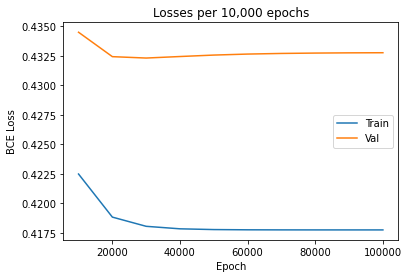

In [79]:
plt.plot(Iterations, losses, label='Train')
plt.plot(Iterations, losses_val, label='Val')
plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.title('Losses per 10,000 epochs')
plt.legend()
plt.show()

# PyTorch: Use k-fold technique to entry dataset division

In [86]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

In [102]:
X_train.shape

torch.Size([8693, 27])

In [87]:
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)

In [114]:
import torch.nn.functional as F

In [108]:
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(27, 128)
        self.layer2 = nn.Linear(128, 256)
        self.layer3 = nn.Linear(256, 128)
        self.layer4 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.layer3(x)
        x = F.relu(x)
        x = self.layer4(x)
        x = torch.sigmoid(x)
        return x

In [115]:
# Define the K-fold Cross Validator
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)

dataset = torch.utils.data.TensorDataset(X_train, y_train)

loss_list = []
acc_list = []

# K-fold Cross Validation model evaluation
for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
    
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
    
    # Define data loaders for training and testing data in this fold
    train_loader = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=32, sampler=train_subsampler)
    valid_loader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=32, sampler=test_subsampler)
    
    # Init the neural network
    simple_nn = SimpleNN()
    optimizer = torch.optim.Adam(simple_nn.parameters(), lr=0.01)
    error = nn.BCELoss()
    
    for epoch in range(300):
        with torch.no_grad():
            valid_loss = 0
            num_right = 0
            for tensor_x, tensor_y in valid_loader:
                tensor_x = tensor_x.float()
                tensor_y = tensor_y.float().reshape(-1, 1)
                output = simple_nn(tensor_x)
                loss = error(output, tensor_y)
                valid_loss += loss.item() * len(tensor_x)
                result = [1 if out >= 0.5 else 0 for out in output]
                num_right += np.sum(np.array(result) == tensor_y.numpy().reshape(-1))
            
            valid_loss = valid_loss / len(valid_loader.sampler.indices)
            valid_accuracy = num_right / len(valid_loader.sampler.indices)
        
            if epoch % 50 == 0:
                print('Valid Loss: {} Accuracy: {} Epoch:{}'.format(valid_loss, valid_accuracy, epoch))
    
        train_loss = 0
        num_right = 0
        for tensor_x, tensor_y in train_loader:
            tensor_x = tensor_x.float()
            tensor_y = tensor_y.float().reshape(-1, 1)
            optimizer.zero_grad()
            output = simple_nn(tensor_x)
            loss = error(output, tensor_y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * len(tensor_x)
            result = [1 if out >= 0.5 else 0 for out in output]
            num_right += np.sum(np.array(result) == tensor_y.numpy().reshape(-1))
        
        train_loss = train_loss / len(train_loader.sampler.indices)
        accuracy = num_right / len(train_loader.sampler.indices)
    
        if epoch % 50 == 0:
            print('Loss: {} Accuracy: {} Epoch:{}'.format(train_loss, accuracy, epoch))
            
    loss_list.append(valid_loss)
    acc_list.append(valid_accuracy)

    print('Training Ended')
print('Average Loss: {} Average Accuracy: {}'.format(np.mean(loss_list), np.mean(acc_list)))  

FOLD 0
--------------------------------
Valid Loss: 0.6900588771335828 Accuracy: 0.5106382978723404 Epoch:0
Loss: 0.4492809001591002 Accuracy: 0.7863100373885533 Epoch:0
Valid Loss: 0.5173561598392243 Accuracy: 0.7947096032202415 Epoch:50
Loss: 0.3342430414157864 Accuracy: 0.8334771354616048 Epoch:50
Valid Loss: 0.8704949558432449 Accuracy: 0.7883841288096607 Epoch:100
Loss: 0.3370252646417977 Accuracy: 0.8350589588725913 Epoch:100
Valid Loss: 1.5327477553851856 Accuracy: 0.7751581368602645 Epoch:150
Loss: 0.38445765413033195 Accuracy: 0.8467069312625827 Epoch:150
Valid Loss: 1.235982003552671 Accuracy: 0.7791834387579069 Epoch:200
Loss: 0.28016166949978427 Accuracy: 0.857204486626402 Epoch:200
Valid Loss: 2.149641885710832 Accuracy: 0.7780333525014376 Epoch:250
Loss: 0.25354328580995655 Accuracy: 0.863819384526891 Epoch:250
Training Ended
FOLD 1
--------------------------------
Valid Loss: 0.6936137077107795 Accuracy: 0.45313398504887864 Epoch:0
Loss: 0.44289992655835553 Accuracy: 0.7